In [79]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# 参数设定
city = 'shanghai'
GRID_SIZE = 50  # meter
target_dt = datetime.datetime(2018, 9, 13, 12, 0)

In [80]:
# 区域边界
if city == 'beijing':
    lon_l, lon_r, lat_b, lat_u = 115.43, 117.52, 39.44, 41.05
if city == 'shanghai':
    lon_l, lon_r, lat_b, lat_u = 120.836619, 122.165824, 30.631414, 31.883925
if city == 'shenzhen':
    lon_l, lon_r, lat_b, lat_u = 113.70, 114.70, 22.45, 22.85
GRID_SIZE = 50  # Meter

# 经纬度步长计算
earth_radius = 6378137.0
pi = 3.1415926535897932384626
meter_per_degree = earth_radius * pi / 180.0
lat_step = GRID_SIZE * (1.0 / meter_per_degree)
ratio = np.cos((lat_b + lat_u) * np.pi / 360)
lon_step = lat_step / ratio
lat_split = int(np.ceil((lat_u - lat_b) / lat_step))
lon_split = int(np.ceil((lon_r - lon_l) / lon_step))

# 起始时间（小时偏移起点）
t0 = datetime.datetime.strptime('20180101 00:00:00', "%Y%m%d %H:%M:%S")

# 读取函数
def read_from_text(file):
    for line in file:
        yield line.strip('\r\n').split('\t')

# 映射回真实经纬度（用于可视化时反查）
def index_to_lon(x_idx):
    return lon_l + x_idx * lon_step

def index_to_lat(y_idx):
    return lat_b + y_idx * lat_step

In [81]:
# 人口热力计数器
heat_counter = Counter()

# 读取并处理数据
with open(f'./record/record_{city}.txt', 'r') as file:
    for trace in tqdm(read_from_text(file), desc="Processing traces"):
        uid, trace = trace
        trace = trace.split('|')

        t_list = [int(trace[i]) for i in range(0, len(trace), 3)]
        x_idx_list = [float(trace[i]) for i in range(1, len(trace), 3)]
        y_idx_list = [float(trace[i]) for i in range(2, len(trace), 3)]

        for t, x_idx, y_idx in zip(t_list, x_idx_list, y_idx_list):
            dt = t0 + datetime.timedelta(hours=t)
            if dt == target_dt:
                xi, yi = int(x_idx), int(y_idx)
                if 0 <= xi < lon_split and 0 <= yi < lat_split:
                    heat_counter[(xi, yi)] += 1

# 构建热力图矩阵
heatmap = np.zeros((lat_split, lon_split))
for (xi, yi), count in heat_counter.items():
    heatmap[yi, xi] = count  # 注意：行是纬度方向

Processing traces: 450695it [03:09, 2374.77it/s]


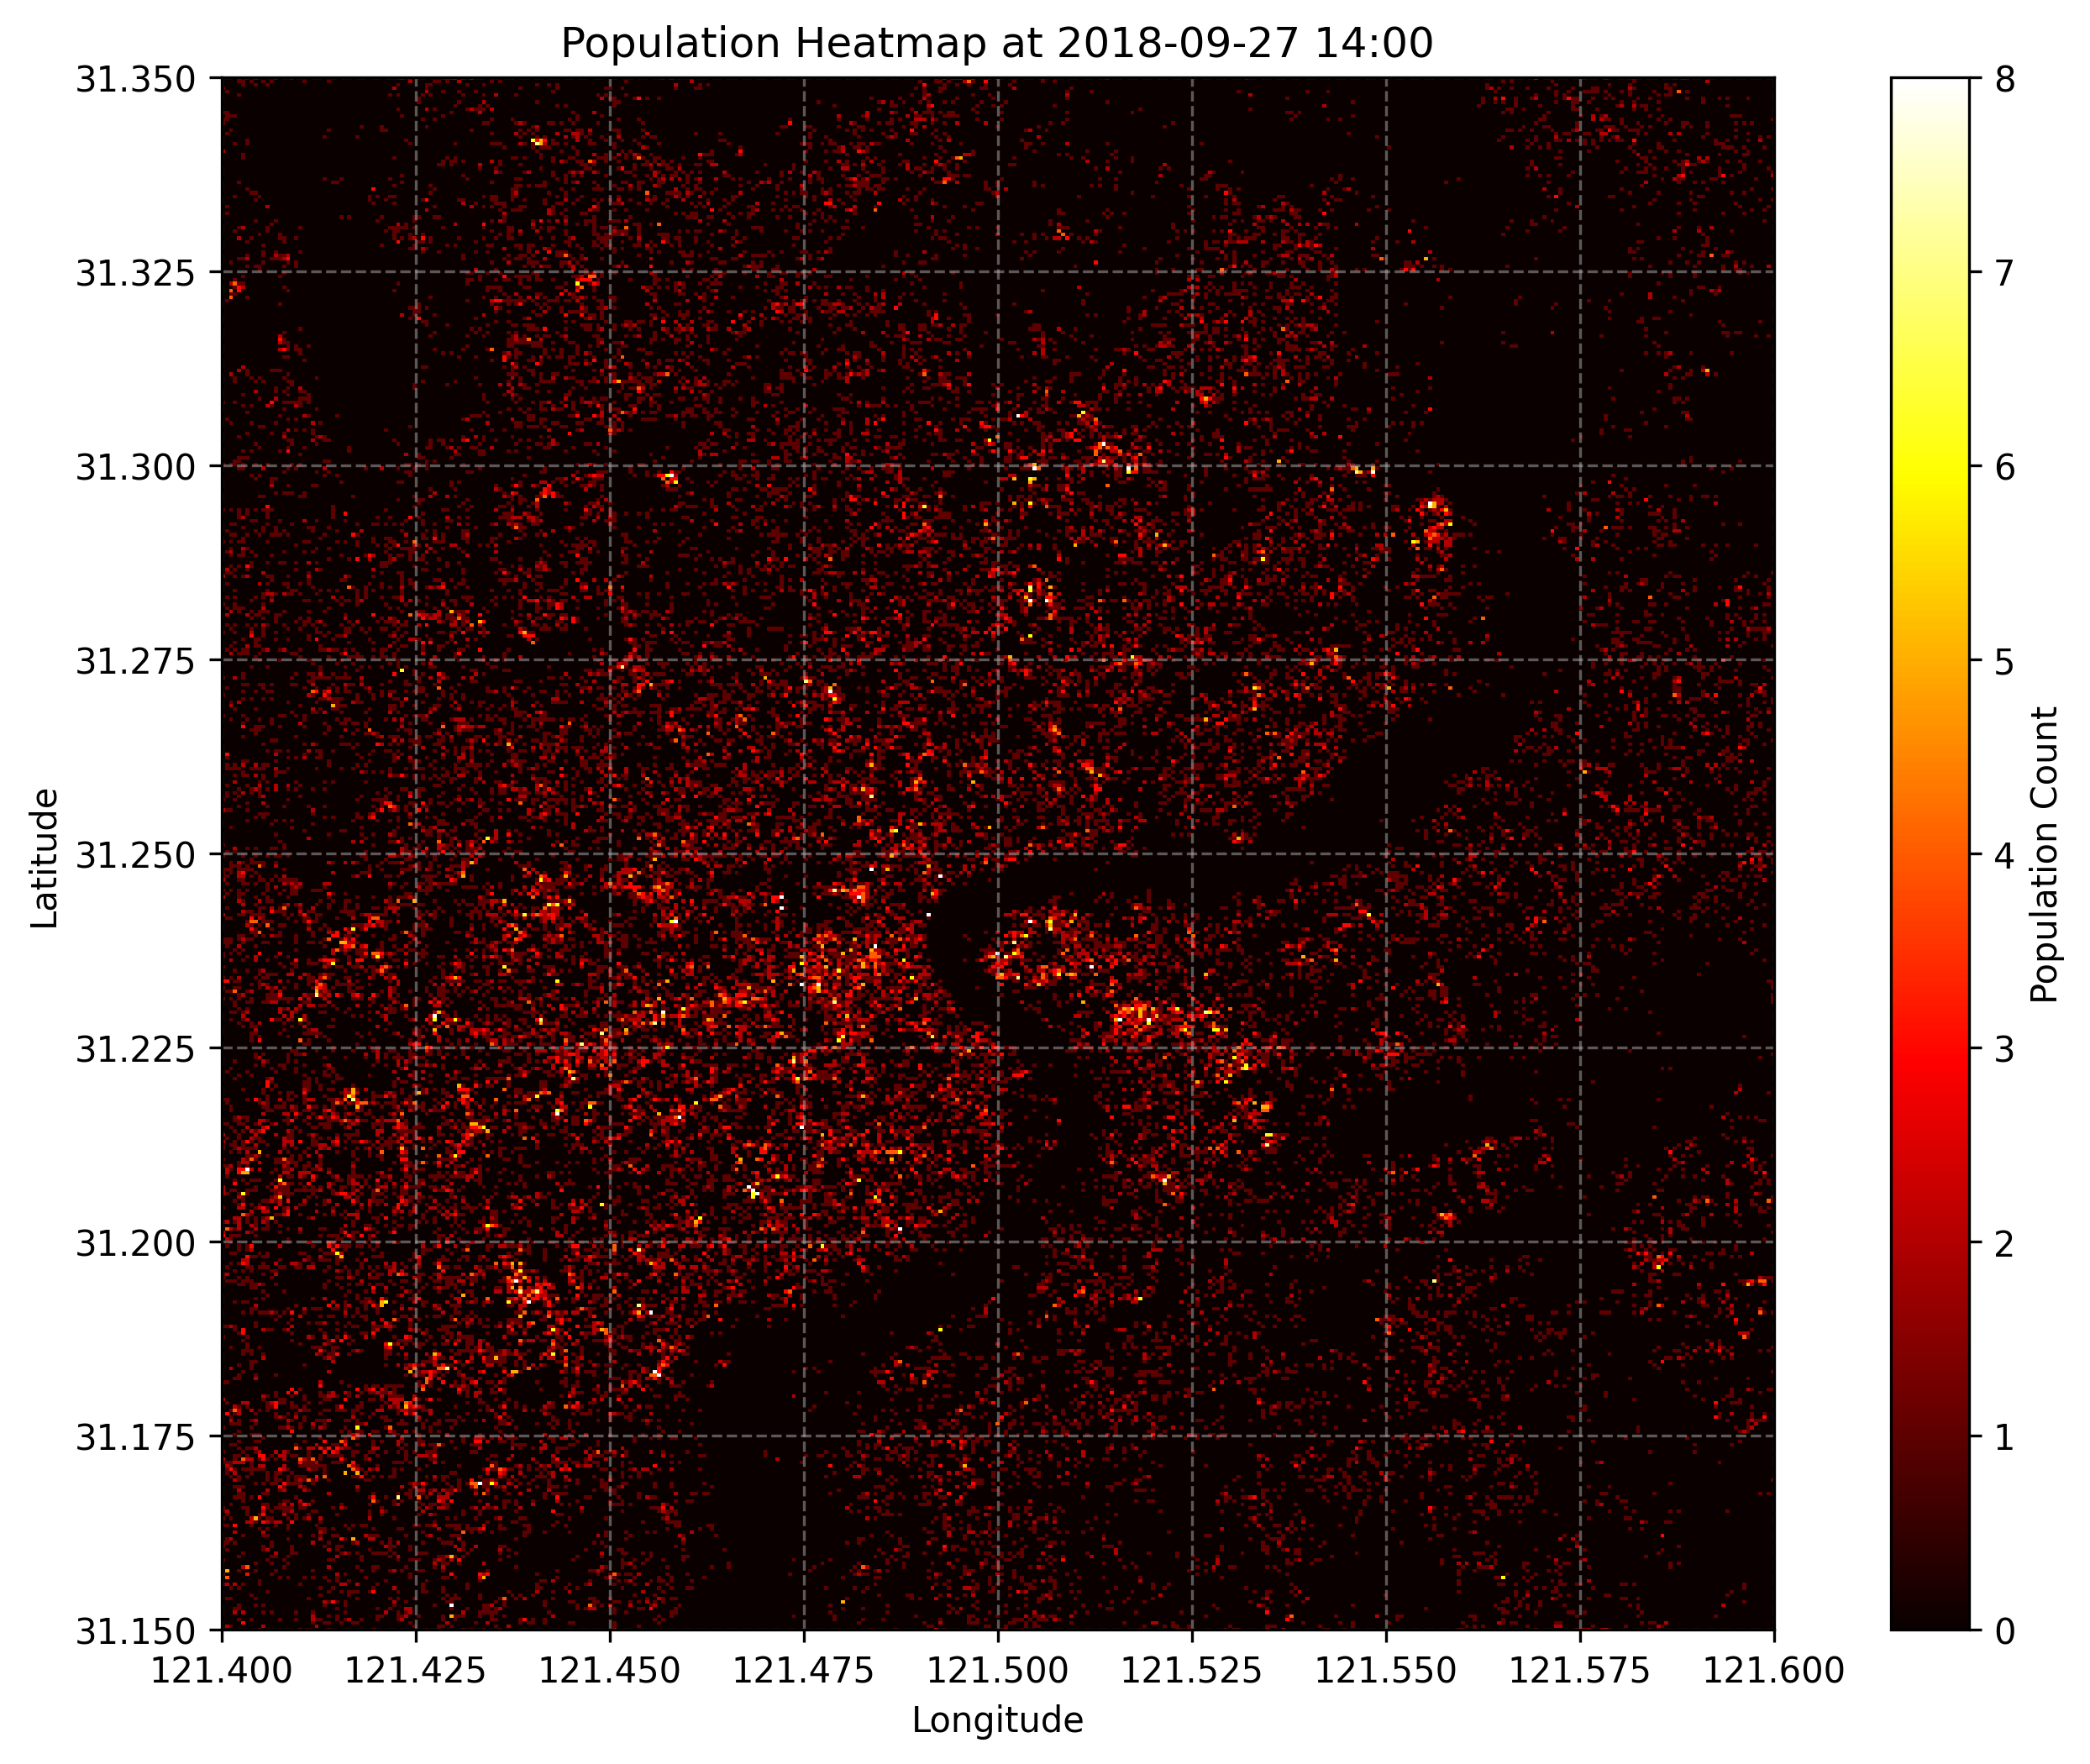

In [82]:
# 计算热力图边界对应的经纬度范围
extent = [
    lon_l,                             # x_min (左边界经度)
    lon_l + lon_step * (lon_split),     # x_max
    lat_b,                             # y_min (底部纬度)
    lat_b + lat_step * (lat_split)      # y_max
]

# 定义需要的经纬度范围
# 上海
lon_min, lon_max = 121.4, 121.6
lat_min, lat_max = 31.15, 31.35
# # 深圳
# lon_min, lon_max = 113.95, 114.15
# lat_min, lat_max = 22.5, 22.7

# 绘图
plt.figure(figsize=(12, 8), dpi=300)
plt.imshow(
    heatmap,
    origin='lower',
    cmap='hot',
    interpolation='nearest',
    vmin=0,
    vmax=8,
    extent=extent  # 用于将索引映射为真实经纬度
)
plt.colorbar(label='Population Count')
plt.title(f'Population Heatmap at {target_dt.strftime("%Y-%m-%d %H:%M")}')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim((lon_min, lon_max))
plt.ylim((lat_min, lat_max))
# plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig(f'./pop_map/heatmap_{city}_{target_dt.strftime("%Y%m%d_%H%M")}.png', bbox_inches='tight')
plt.show()

# 根据经纬度范围和步长生成网格
grid_lat = np.arange(lat_b, lat_u, lat_step)
grid_lon = np.arange(lon_l, lon_r, lon_step)

# 计算经纬度范围在热力图中的索引
lon_idx_min = np.searchsorted(grid_lon, lon_min)
lon_idx_max = np.searchsorted(grid_lon, lon_max)
lat_idx_min = np.searchsorted(grid_lat, lat_min)
lat_idx_max = np.searchsorted(grid_lat, lat_max)

# 提取热力图矩阵中的相应部分
heatmap_subset = heatmap[lat_idx_min:lat_idx_max+1, lon_idx_min:lon_idx_max+1]

# 保存为 .npy 文件
np.save(f'./pop_map/heatmap_subset_{city}_{target_dt.strftime("%Y%m%d_%H%M")}.npy', heatmap_subset)